# Labeled Faces in the wild dataset

This dataset
contains face images of celebrities downloaded from the Internet, and it includes
faces of politicians, singers, actors, and athletes from the early 2000s.

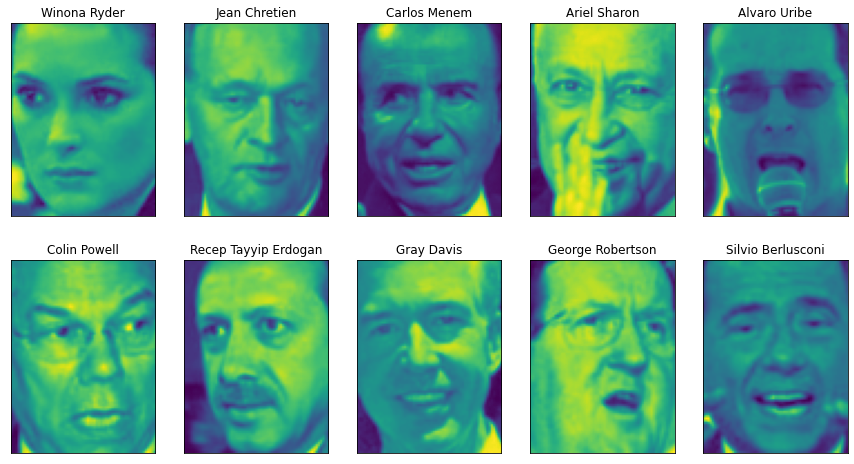

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape
fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])


There are 3,023 images (data points), each 87×65=5,655 pixels large (original features), 
belonging to 62 different people (classes).
The dataset is a bit skewed, however, containing a lot of images of George W. Bush
and Colin Powell, as you can see below.
To make the data less skewed, we will only take up to 50 images. of each person.
The number of images is then reduced from 3,023 to 2,063, while the number of 
original features ( pixels) for each image (data points) remains 87×65=5,655

In [ ]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]
y_people = people.target[mask]
# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.
print("X_people.images.shape: {}".format(X_people.shape))



# Split in training and test set

In [9]:
from sklearn.model_selection import train_test_split

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
X_people, y_people, stratify=y_people, random_state=0)

# Pretreatement: dimensionality reduction

## Principal Component Analysis

Principal component analysis is a method that rotates the dataset in a way such that
the rotated features are statistically uncorrelated. This rotation is often followed by
selecting only a subset of the new features, according to how important they are for
explaining the data.

The first plot (top left) shows the original data points, colored to distinguish among
them. The algorithm proceeds by first finding the direction of maximum variance,
labeled “Component 1.” This is the direction (or vector) in the data that contains most
of the information, or in other words, the direction along which the features are most
correlated with each other. Then, the algorithm finds the direction that contains the
most information while being orthogonal (at a right angle) to the first direction.

We can use PCA for dimensionality reduction by retaining only some of the principal
components. In this example, we might keep only the first principal component, as shown in the third panel of the following Figure. This reduces the data from a
two-dimensional dataset to a one-dimensional dataset.

Finally, we can undo the rotation and add the mean back to the data. This will result
in the data shown in the last panel. These points are in the original feature
space, but we kept only the information contained in the first principal component.
This transformation is sometimes used to remove noise effects from the data or
visualize what part of the information is retained using the principal components.



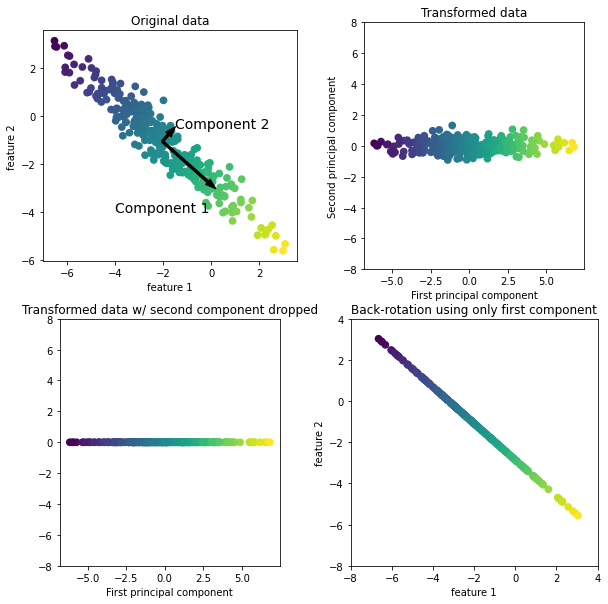

In [2]:
mglearn.plots.plot_pca_illustration()


### Feature extraction 

An application of PCA is feature extraction. The idea
behind feature extraction is that it is possible to find a representation of your data
that is better suited to analysis than the raw representation you were given. A great
example of an application where feature extraction is helpful is with images. Images
are made up of pixels, usually stored as red, green, and blue (RGB) intensities.
Objects in images are usually made up of thousands of pixels, and only together are
they meaningful. Importantly, remember that each image represents a data point, the pixels represents the original features and the colour intensity of each pixel in a picture is the class, as this identifies the subject of the picture.

Here PCA is used to show how the distances between pixels of the training and target images ( at the heart of the fit carried out by knearest neighbours, see below) along principal components rather than the original features space can improve accuracy. 

Here, we enable the
whitening option of PCA, which rescales the principal components to have the same
scale. This is the same as using StandardScaler after the transformation. Reusing some illustrative data, we can show that whitening corresponds to not only rotating the data, but
also rescaling it so that the center panel is a circle instead of an ellipse


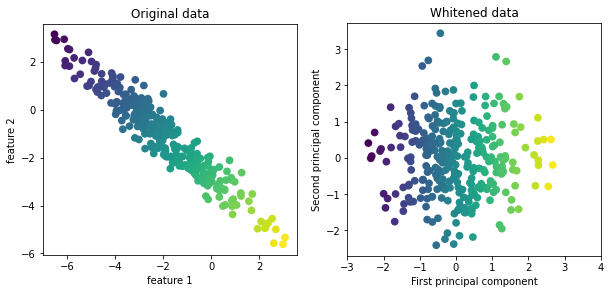

In [12]:
mglearn.plots.plot_pca_whitening()

We fit the PCA object to the training data and extract the first 100 principal components.
Then we transform the training and test data. This means that we 
rotate the data and then drop the components with low variance. The new data has 100 features, the first 100 principal components.

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


For image data, we can also easily visualize the principal components.

While we certainly cannot understand all aspects of these components, we can guess
which aspects of the face images some of the components are capturing. The first
component seems to mostly encode the contrast between the face and the background,
the second component encodes differences in lighting between the right and
the left half of the face, and so on. While this representation is slightly more semantic
than the raw pixel values, it is still quite far from how a human might perceive a face.
As the PCA model is based on pixels, the alignment of the face (the position of eyes,
chin, and nose) and the lighting both have a strong influence on how similar two
images are in their pixel representation. 

pca.components_.shape: (100, 5655)


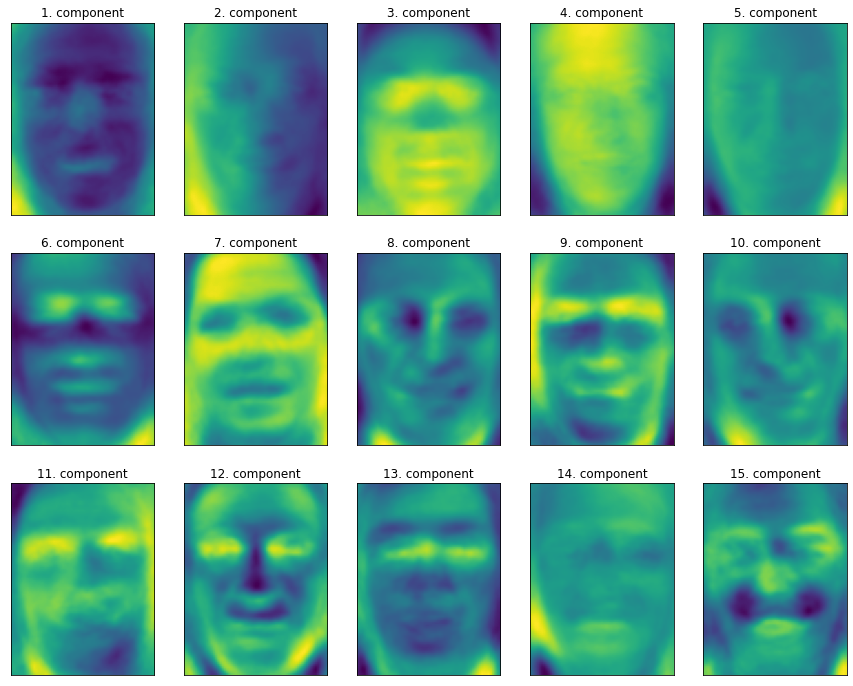

In [16]:
print("pca.components_.shape: {}".format(pca.components_.shape))

fix, axes = plt.subplots(3, 5, figsize=(15, 12),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
    cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

Another useful interpretation is to try to find the weights of PCAs when expressing the test image as linear combination of PCAs in the rotated space. 

We can also try to understand what a PCA model is doing is by looking at
the reconstructions of the original data using only some components. This can be shown in the figure below where after reducing the data to only some principal components, we rotate them back into the original space. This return to the original feature space
can be done using the inverse_transform method. Here, we visualize the reconstruction
of some faces using 10, 50, 100, 500, components.

You can see that when we use only the first 10 principal components, only the essence
of the picture, like the face orientation and lighting, is captured. By using more and
more principal components, more and more details in the image are preserved. This corresponds to extending the linear combination in the rotated space to include more and more terms. Furthermore the number of PCAs sufficient to well describe the test image depends on the picture: for instance, straight alligned faces needs less PCAs then faces presenting an inclination angle. 
Using as many components as there are pixels would mean that we would not discard
any information after the rotation, and we would reconstruct the image perfectly.

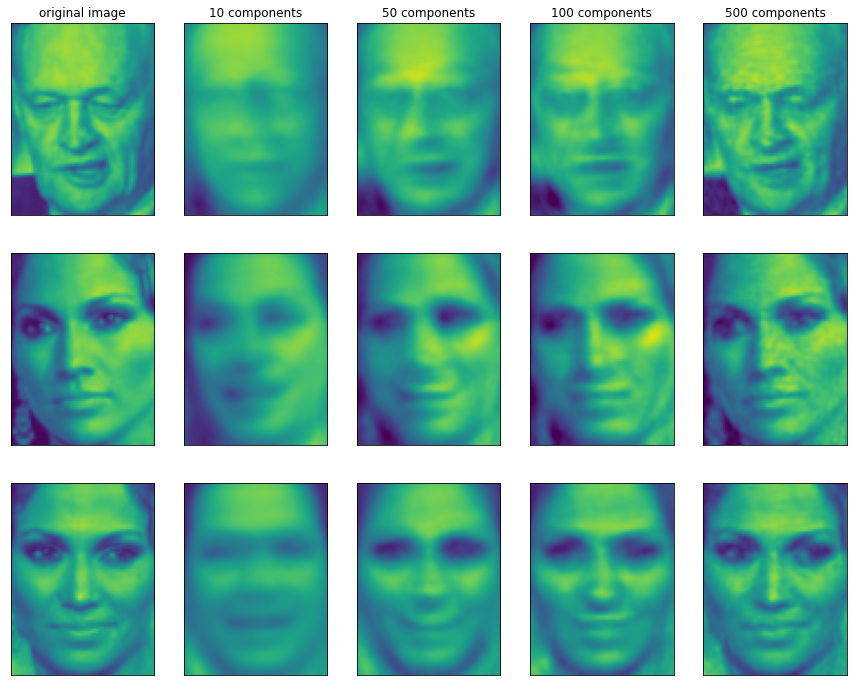

In [25]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

We can also try to use PCA to visualize all the faces in the dataset in a scatter plot
using the first two principal components (Figure 3-12), with classes given by who is
shown in the image. 

As you can see, when we use only the first two principal components the whole data
is just a big blob, with no separation of classes visible. This is not very surprising,
given that even with 10 components, as shown in the previous Figure, PCA only captures
very rough characteristics of the faces. 

Interestingly, this result is in contrast with what we can find in the cancer data where the first two components rapresentation offers well separeted classes, to the point that even a linear classifier could be used to fit the data. However remember that in that case we had only 2 classes, 30 original features and 569 data points, while here we have 62 classes, 5655 features and 2063 data points. Reducing dimensionality from 30 to 2 for a 2 classes dataset gives a much better generalization than reducing dimensionality from 5655 to 2 for a 62 classes dataset. In other words the dimensionality reduction cannot be too drastic if we want our model to well generalize.

Text(0, 0.5, 'Second principal component')

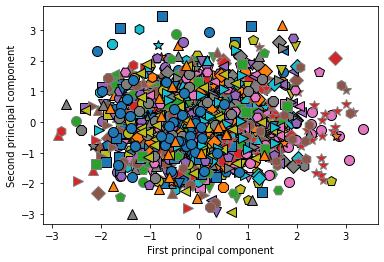

In [24]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

## Non-Negative Matrix Factorization

Non-negative matrix factorization is another unsupervised learning algorithm that
aims to extract useful features. It works similarly to PCA and can also be used for
dimensionality reduction. As in PCA, we are trying to write each data point as a
weighted sum of some components. But whereas in PCA
we wanted components that were orthogonal and that explained as much variance of
the data as possible, in NMF, we want the components and the coefficients to be nonnegative;
that is, we want both the components and the coefficients to be greater than
or equal to zero. Consequently, this method can only be applied to data where each
feature is non-negative, as a non-negative sum of non-negative components cannot
become negative.

While PCA finds the optimum directions in terms of reconstruction.
NMF is usually not used for its ability to reconstruct or encode data, but rather
for finding interesting patterns within the data.

The process of decomposing data into a non-negative weighted sum is particularly
helpful for data that is created as the addition (or overlay) of several independent
sources, such as an audio track of multiple people speaking, or music with many
instruments. 

We need to ensure that our data is positive for NMF
to be able to operate on the data. Then, you can think of the non-negative components
that are extracted as directions from (0, 0) toward the data. For NMF with two components, as shown on the left, it is clear that all points in the
data can be written as a positive combination of the two components. If there are
enough components to perfectly reconstruct the data (as many components as there
are features), the algorithm will choose directions that point toward the extremes of
the data. If we only use a single component, NMF creates a component that points toward the
mean, as pointing there best explains the data. You can see that in contrast with PCA,
reducing the number of components not only removes some directions, but creates
an entirely different set of components! Components in NMF are also not ordered in
any specific way, so there is no “first non-negative component”: all components play
an equal part.

C:\Users\Giuseppe Marino\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\Giuseppe Marino\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


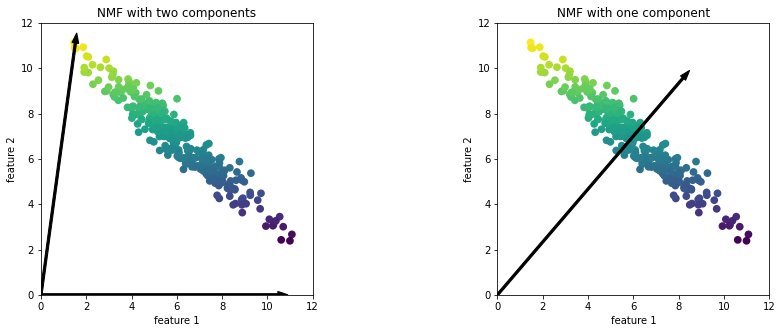

In [26]:
mglearn.plots.plot_nmf_illustration()

Let’s inspect how the number of components impacts how well the Labeled Faces in the Wild data can be
reconstructed using NMF. The quality of the back-transformed data is similar to when using PCA, but slightly
worse, and we can see how different interesting patterns witihn the images are selected with respect to PCA.

________________________________________________________________________________
[Memory] Calling mglearn.plot_nmf.nmf_faces...
nmf_faces(array([[0.535948, ..., 0.243137],
       ...,
       [0.043137, ..., 0.596078]], dtype=float32), 
array([[0.237908, ..., 0.269281],
       ...,
       [0.4     , ..., 0.254902]], dtype=float32))


C:\Users\Giuseppe Marino\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\Giuseppe Marino\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\Giuseppe Marino\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
C:\Users\Giuseppe Marino\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum numbe

____________________________________________________nmf_faces - 1432.3s, 23.9min


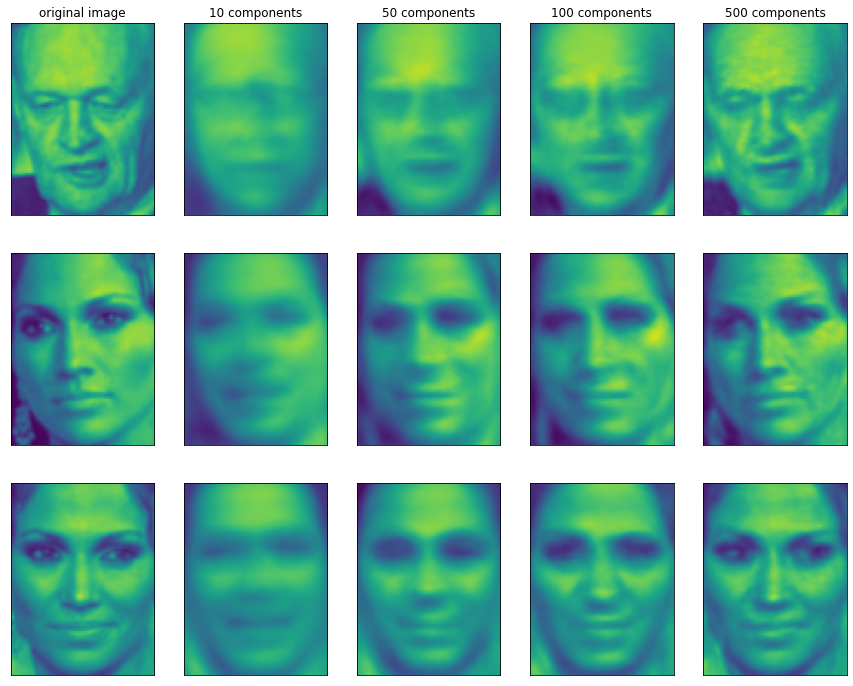

In [28]:
mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)


Let’s try extracting only a few components (say, 15). These components are all positive, and so resemble prototypes of faces much more so
than the components shown for PCA. For example, one can clearly see
that component 3 shows a face rotated somewhat to the right, while component 7
shows a face somewhat rotated to the left.

C:\Users\Giuseppe Marino\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


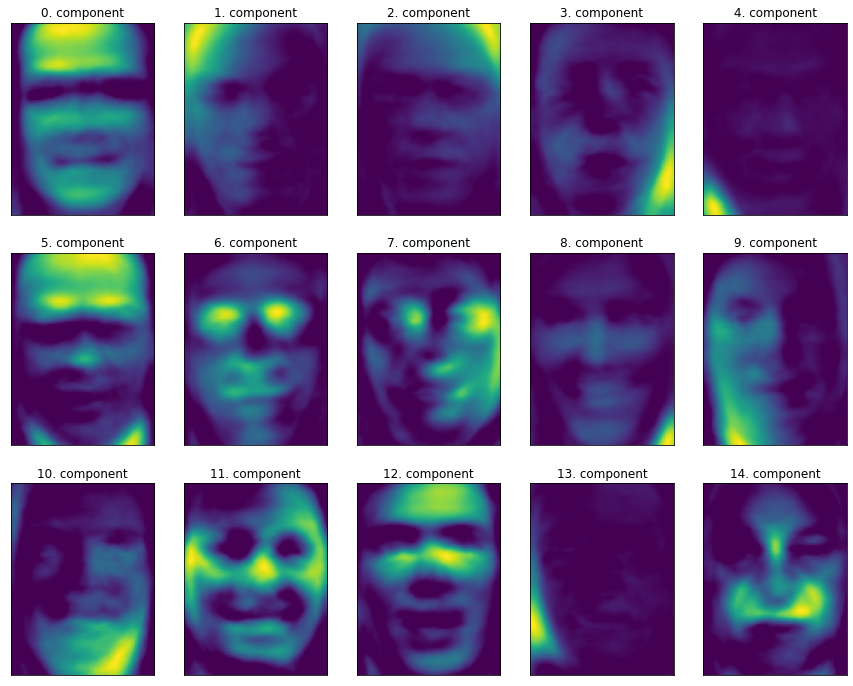

In [27]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

Let’s look at the images for which components 3 and 7 are particularly strong. As expected, faces that have a high coefficient for component 3 are faces looking to
the right, while faces with a high coefficient for component 7 are looking
to the left .

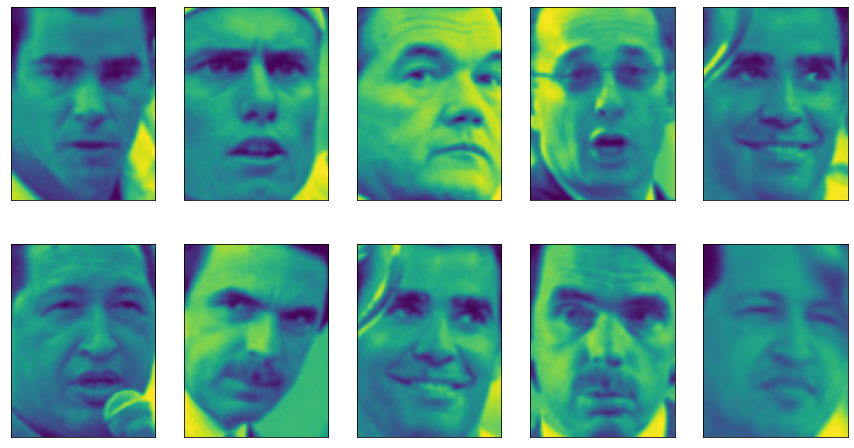

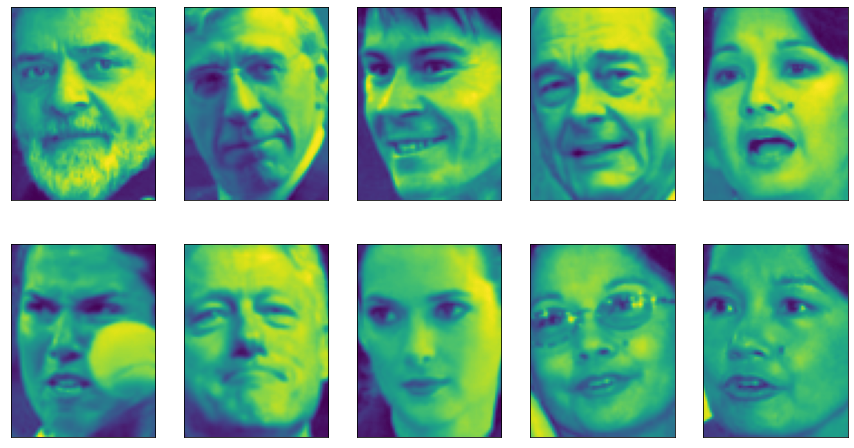

In [32]:
compn = 3
# sort by 3rd component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

compn = 7
# sort by 7th component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

# Model & Learning curve

## k-Nearest Neighbors

A common task in face recognition is to ask if a previously unseen face belongs to a
known person from a database. This has applications in photo collection, social
media, and security applications. One way to solve this problem would be to build a
classifier where each person is a separate class. However, there are usually many different
people in face databases, and very few images of the same person (i.e., very few
training examples per class). That makes it hard to train most classifiers. Additionally, you often want to be able to add new people easily, without needing to retrain a large
model.
A simple solution is to use a one-nearest-neighbor classifier that looks for the most
similar face image to the face you are classifying. This classifier could in principle
work with only a single training example per class. Let’s take a look at how well
KNeighborsClassifier does here.

We obtain an accuracy of 23%, which is not actually that bad for a 62-class classification
problem (random guessing would give you around 1/62 = 1.5% accuracy), but
is also not great. We only correctly identify a person every fourth time.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# build a KNeighborsClassifier using one neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


## k-Nearest Neighbors with PCA

Computing distances in the original pixel space is quite
a bad way to measure similarity between faces. When using a pixel representation to
compare two images, we compare the grayscale value of each individual pixel to the
value of the pixel in the corresponding position in the other image. Using
pixel distances means that shifting a face by one pixel to the right corresponds to a
drastic change, with a completely different representation.

This is where PCA comes in. PCA is used to show how the distances between pixels of the training and target images along principal components rather than the original features space can improve accuracy. 

Our accuracy improved quite significantly, from 23% to 31%, confirming our
intuition that the principal components might provide a better representation of the
data.

In [15]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31
